In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

# Define data directory and image dimensions
data_dir = '/content/drive/MyDrive/adulterationnew'
img_height, img_width = 224, 224

# Load and preprocess data
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=32
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=32
)

# Optimize data pipeline
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Build the CNN model for feature extraction
base_model = EfficientNetB1(input_shape=(img_height, img_width, 3), include_top=False, weights="imagenet")
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
cnn_output = layers.Dense(12, activation="softmax")(x)
cnn_model = models.Model(inputs=base_model.input, outputs=cnn_output)

# Compile the CNN model
cnn_model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

# Train the CNN model
early_stopping = EarlyStopping(monitor='val_loss', patience=7, verbose=1, restore_best_weights=True)
history = cnn_model.fit(train_ds, validation_data=val_ds, epochs=15, callbacks=[early_stopping])



Found 4800 files belonging to 12 classes.
Using 3840 files for training.
Found 4800 files belonging to 12 classes.
Using 960 files for validation.
27018416/27018416 [==============================] - 0s 0us/step
Epoch 1/15
120/120 [==============================] - 1056s 8s/step - loss: 1.7306 - accuracy: 0.4289 - val_loss: 1.8006 - val_accuracy: 0.3906
Epoch 2/15
120/120 [==============================] - 47s 392ms/step - loss: 0.7160 - accuracy: 0.7594 - val_loss: 0.9091 - val_accuracy: 0.6385
Epoch 3/15
120/120 [==============================] - 47s 389ms/step - loss: 0.3784 - accuracy: 0.8849 - val_loss: 0.4769 - val_accuracy: 0.7604
Epoch 4/15
120/120 [==============================] - 46s 385ms/step - loss: 0.2402 - accuracy: 0.9349 - val_loss: 0.4159 - val_accuracy: 0.7896
Epoch 5/15
120/120 [==============================] - 46s 386ms/step - loss: 0.1496 - accuracy: 0.9635 - val_loss: 0.4769 - val_accuracy: 0.7917
Epoch 6/15
120/120 [==============================] - 47s 387ms/

1/1 [==============================] - 0s 42ms/step
CNN + KNN Classifier Metrics:
Accuracy: 0.8135416666666667
Precision: 0.8141538679349168
Recall: 0.8135416666666667
Confusion Matrix:
[[66  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 77  0  0  0  1  0  0  0  0  0  0]
 [ 0  3 63  0  0  0  0  0  0  0  0  0]
 [ 0  1  2 72  4  0  0  3  0  0  0  0]
 [ 0  0  1  0 82  0  1  0  3  0  0  0]
 [ 0  0  0  0  0 61  0 17  0  0  0  0]
 [ 0  0  0  0  0  0 44  0 39  0  4  0]
 [ 0  0  0  2  0 15  0 35  0  0 21  0]
 [ 0  0  0  0  1  0 45  0 41  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 85  0  0]
 [ 0  0  0  0  0  0  0 16  0  0 70  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 85]]
Classification Report:
                          precision    recall  f1-score   support

jeerapowder normalsample       1.00      1.00      1.00        66
       jeerapowderwith5%       0.95      0.99      0.97        78
      jeerapowderwith10%       0.95      0.95      0.95        66
      jeerapowderwith15%       0.97      0.88      0.92  

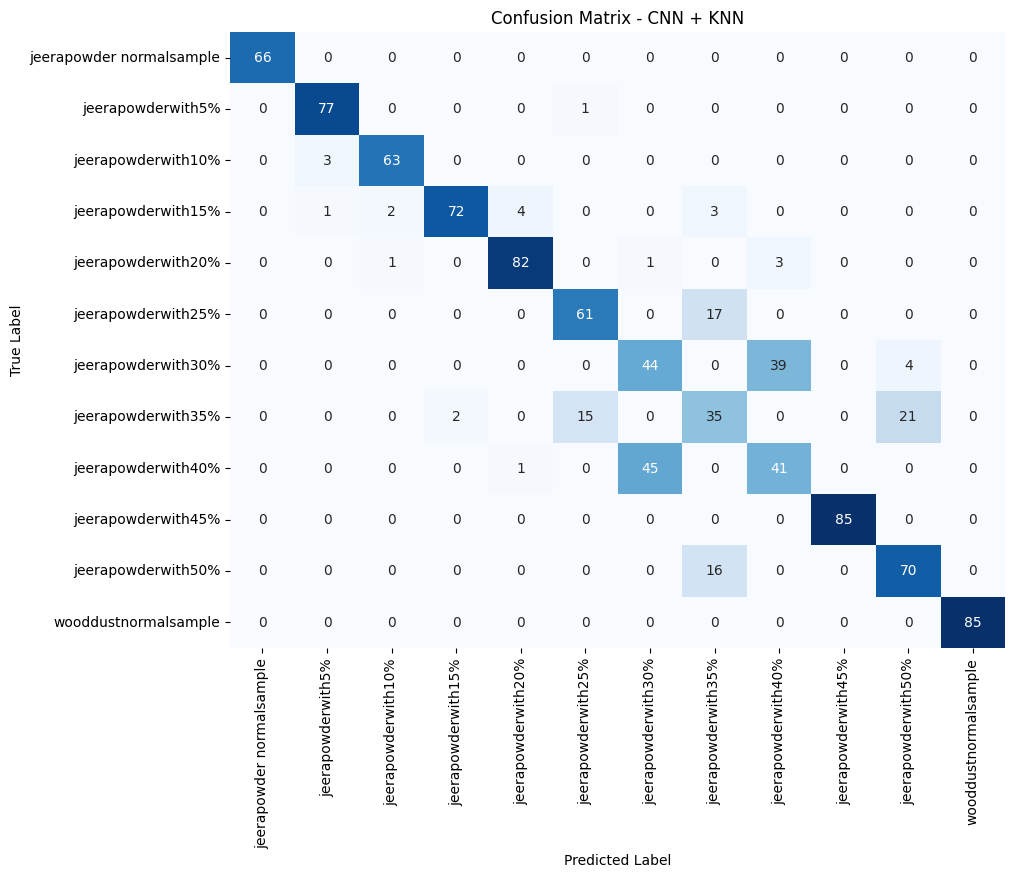

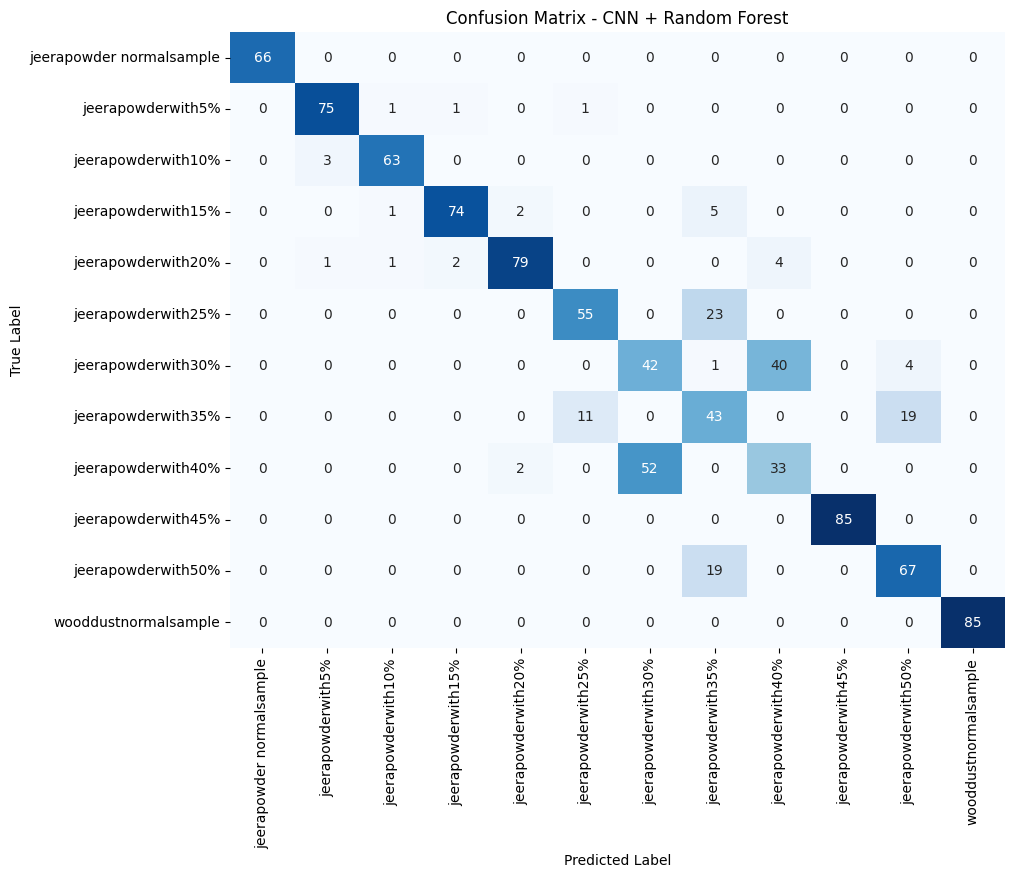

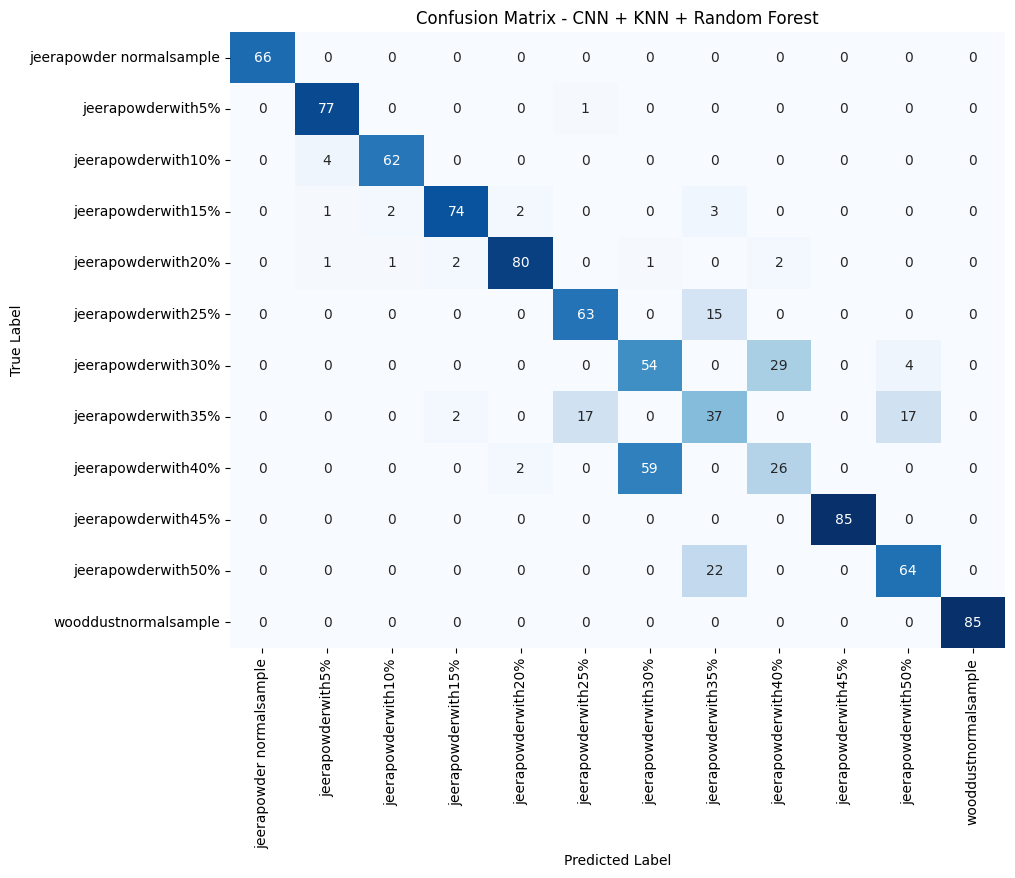

In [ ]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator, ClassifierMixin


# Function to extract features using the CNN model
def extract_features(dataset, feature_extractor):
    features, labels = [], []
    for images, labels_batch in dataset:
        features_batch = feature_extractor.predict(images)
        features.append(features_batch)
        labels.append(labels_batch.numpy())
    return np.vstack(features), np.concatenate(labels)

# Extract features using the trained CNN model
feature_extractor_model = models.Model(inputs=cnn_model.input, outputs=cnn_model.layers[-2].output)
train_features, train_labels = extract_features(train_ds, feature_extractor_model)
val_features, val_labels = extract_features(val_ds, feature_extractor_model)

# Reshape features for RandomForest and KNN input
train_features_flat = np.reshape(train_features, (train_features.shape[0], -1))
val_features_flat = np.reshape(val_features, (val_features.shape[0], -1))

# Label encoding
le = LabelEncoder()
train_labels_enc = le.fit_transform(train_labels)
val_labels_enc = le.transform(val_labels)

# Define the ensemble classifier
class EnsembleClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, models):
        self.models = models

    def fit(self, X, y):
        for model in self.models:
            model.fit(X, y)
        return self

    def predict(self, X):
        predictions = np.array([model.predict(X) for model in self.models])
        final_preds = []
        for i in range(X.shape[0]):
            # Perform majority voting for each sample
            unique, counts = np.unique(predictions[:, i], return_counts=True)
            final_preds.append(unique[np.argmax(counts)])
        return np.array(final_preds)

# Define and evaluate the models
def evaluate_model(model, X_val, y_val, class_names):
    y_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred, average='weighted')
    recall = recall_score(y_val, y_pred, average='weighted')
    conf_matrix = confusion_matrix(y_val, y_pred)
    class_report = classification_report(y_val, y_pred, target_names=class_names)
    return accuracy, precision, recall, conf_matrix, class_report

# Create and evaluate individual and ensemble models
class_names = ["jeerapowder normalsample", "jeerapowderwith5%", "jeerapowderwith10%", "jeerapowderwith15%",
               "jeerapowderwith20%", "jeerapowderwith25%", "jeerapowderwith30%", "jeerapowderwith35%",
               "jeerapowderwith40%", "jeerapowderwith45%", "jeerapowderwith50%", "wooddustnormalsample"]

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
knn_model = KNeighborsClassifier(n_neighbors=5)

# CNN + KNN
cnn_knn_model = EnsembleClassifier(models=[knn_model])
cnn_knn_model.fit(train_features_flat, train_labels_enc)
accuracy_cnn_knn, precision_cnn_knn, recall_cnn_knn, conf_matrix_cnn_knn, class_report_cnn_knn = evaluate_model(cnn_knn_model, val_features_flat, val_labels_enc, class_names)

print('CNN + KNN Classifier Metrics:')
print(f'Accuracy: {accuracy_cnn_knn}')
print(f'Precision: {precision_cnn_knn}')
print(f'Recall: {recall_cnn_knn}')
print('Confusion Matrix:')
print(conf_matrix_cnn_knn)
print('Classification Report:')
print(class_report_cnn_knn)

# CNN + Random Forest
cnn_rf_model = EnsembleClassifier(models=[rf_model])
cnn_rf_model.fit(train_features_flat, train_labels_enc)
accuracy_cnn_rf, precision_cnn_rf, recall_cnn_rf, conf_matrix_cnn_rf, class_report_cnn_rf = evaluate_model(cnn_rf_model, val_features_flat, val_labels_enc, class_names)

print('\nCNN + Random Forest Classifier Metrics:')
print(f'Accuracy: {accuracy_cnn_rf}')
print(f'Precision: {precision_cnn_rf}')
print(f'Recall: {recall_cnn_rf}')
print('Confusion Matrix:')
print(conf_matrix_cnn_rf)
print('Classification Report:')
print(class_report_cnn_rf)

# CNN + KNN + Random Forest
cnn_knn_rf_model = EnsembleClassifier(models=[rf_model, knn_model])
cnn_knn_rf_model.fit(train_features_flat, train_labels_enc)
accuracy_cnn_knn_rf, precision_cnn_knn_rf, recall_cnn_knn_rf, conf_matrix_cnn_knn_rf, class_report_cnn_knn_rf = evaluate_model(cnn_knn_rf_model, val_features_flat, val_labels_enc, class_names)

print('\nCNN + KNN + Random Forest Classifier Metrics:')
print(f'Accuracy: {accuracy_cnn_knn_rf}')
print(f'Precision: {precision_cnn_knn_rf}')
print(f'Recall: {recall_cnn_knn_rf}')
print('Confusion Matrix:')
print(conf_matrix_cnn_knn_rf)
print('Classification Report:')
print(class_report_cnn_knn_rf)

# Plot confusion matrix using seaborn for better visualization
def plot_confusion_matrix(conf_matrix, class_names, title):
    df_cm = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)
    plt.figure(figsize=(10, 8))
    sns.heatmap(df_cm, annot=True, fmt='g', cmap='Blues', cbar=False)
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

plot_confusion_matrix(conf_matrix_cnn_knn, class_names, 'Confusion Matrix - CNN + KNN')
plot_confusion_matrix(conf_matrix_cnn_rf, class_names, 'Confusion Matrix - CNN + Random Forest')
plot_confusion_matrix(conf_matrix_cnn_knn_rf, class_names, 'Confusion Matrix - CNN + KNN + Random Forest')